# Noise2Self-inspired Optopatch moving denoising

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace
from cellmincer.opto_utils import crop_center, get_nn_spatio_temporal_mean
from cellmincer.opto_denoise import get_minimum_padding
from cellmincer.opto_denoise import UNet, \
    generate_occluded_training_data, get_loss_end_to_end, \
    generate_input_for_single_frame_denoising, \
    denoise_end_to_end

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

## Configuration

In [2]:
# list of Optopatch movies
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy'
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'
model_root = '/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models'

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

### Model config

In [51]:
model_prefix = 'rc1__unreg'
denoiser_config_path = os.path.join(model_root, 'denoiser_config__rc1__unreg__000000.json')

if denoiser_config_path is None:
    # this configuration requires 16gb of GPU memory (e.g. Tesla V100)
    denoiser_config = {
        'unet_depth': 3,  # depth of a unet per-frame feature extractor
        'unet_wf': 6,  # log number of unet filters in the first layer
        'unet_readout_hidden_layer_channels_list': [64, 32, 16],
        'unet_readout_kernel_size': 5,
        'unet_kernel_size': 3,
        't_order': 15,  # denoising filter taps
        'occlusion_prob': 0.01,  # fraction of pixels to occlude during training
        'occlusion_strategy': 'random',  # how to occlude?
        'batch_norm': False,  # enable batch norm (False)
    }
else:
    logging.warning(f'Loading denoising model configuration from {denoiser_config_path} ...')
    with open(denoiser_config_path, 'r') as f:
        denoiser_config = json.load(f)

In [52]:
x_padding, y_padding = get_minimum_padding(
    x_window=512,
    y_window=180,
    denoiser_config=denoiser_config)

print(f'x-padding: {x_padding}px')
print(f'y-padding: {y_padding}px')

assert denoiser_config['t_order'] > 0 and denoiser_config['t_order'] % 2 == 1
assert 0. < denoiser_config['occlusion_prob'] < 1.0

x-padding: 54px
y-padding: 68px


## Load datasets

In [7]:
# setup datasets
ws_base_list = []
for opto_mov_path in opto_mov_path_list[:1]:
    ws_base_list.append(OptopatchBaseWorkspace(opto_mov_path, logger))
n_datasets = len(ws_base_list)

ws_denoising_list = []
for ws_base in ws_base_list:
    ws_denoising = OptopatchDenoisingWorkspace(ws_base, x_padding, y_padding)
    ws_denoising_list.append(ws_denoising)

## Instantiate the denoising model

In [53]:
end_to_end_denoiser = UNet(
    in_channels=ws_denoising_list[0].n_global_features + denoiser_config['t_order'],
    out_channels=1,
    depth=denoiser_config['unet_depth'],
    wf=denoiser_config['unet_wf'], 
    batch_norm=denoiser_config['batch_norm'], 
    unet_kernel_size=denoiser_config['unet_kernel_size'],
    readout_hidden_layer_channels_list=denoiser_config['unet_readout_hidden_layer_channels_list'],
    readout_kernel_size=denoiser_config['unet_readout_kernel_size'],
    activation=torch.nn.ReLU(),
    up_mode='upconv',
    padding=False,
    device=device,
    dtype=dtype)

### Train

In [16]:
from contextlib import contextmanager

@contextmanager
def evaluating(net):
    '''Temporarily switch to evaluation mode.'''
    istrain = net.training
    try:
        net.eval()
        yield net
    finally:
        if istrain:
            net.train()
    
def generate_denoised_movie(
        ws_base_list,
        ws_denoising_list,
        end_to_end_denoiser,
        i_dataset,
        i_t_begin,
        i_t_end,
        x0,
        y0,
        x_window,
        y_window):

    denoised_movie_txy = np.zeros(
        (i_t_end - i_t_begin, ws_base_list[0].width, ws_base_list[0].height),
        dtype=np.float32)

    with evaluating(end_to_end_denoiser):
        
        for i_t in range(i_t_begin, i_t_end):

            denoising_input_data = generate_input_for_single_frame_denoising(
                ws_base_list=ws_base_list,
                ws_denoising_list=ws_denoising_list,
                i_dataset=i_dataset,
                i_t=i_t,
                t_order=denoiser_config['t_order'],
                x0=x0,
                y0=y0,
                x_window=x_window,
                y_window=y_window,
                device=device,
                dtype=dtype)

            denoised_frame_xy = denoise_end_to_end(
                denoising_input_data,
                ws_base_list=ws_base_list,
                ws_denoising_list=ws_denoising_list,
                end_to_end_denoiser=end_to_end_denoiser)

            denoised_movie_txy[
                i_t - i_t_begin,
                x0:(x0 + x_window),
                y0:(y0 + y_window)] = denoised_frame_xy.cpu().numpy()

    return denoised_movie_txy


def get_denoised_movie_sma_txy(denoised_movie_txy_list):
    n_movies = len(denoised_movie_txy_list)
    denoised_movie_sma_txy = denoised_movie_txy_list[0].copy() / n_movies
    for denoised_movie_txy in denoised_movie_txy_list[1:]:
        denoised_movie_sma_txy += (denoised_movie_txy / n_movies)
    return denoised_movie_sma_txy


def save_model_state(model_root, model_prefix, index, save_adam_state=True):
    full_model_prefix = 'f{model_prefix}__{index:06d}'
    with open(os.path.join(model_root, f'denoiser_config__{full_model_prefix}.json'), 'w') as f:
        json.dump(denoiser_config, f)
    torch.save(
        end_to_end_denoiser.state_dict(),
        os.path.join(model_root, f'end_to_end_denoiser__{full_model_prefix}.pt'))
    if save_adam_state:
        torch.save(
            optim.state_dict(),
            os.path.join(model_root, f'adam_state__{full_model_prefix}.pt'))


def load_model_state(model_root, model_prefix, index):
    model_path = os.path.join(model_root, f'end_to_end_denoiser__{model_prefix}__{index:06d}.pt')
    return torch.load(model_path)


def get_swa_state_dict(model_root, model_prefix, begin_index, end_index):
    first_state = load_model_state(model_root, model_prefix, begin_index)
    keys = list(first_state.keys())

    ave_state = first_state
    n_summed = 1
    for index in range(begin_index + 1, end_index):
        try:
            c_state = load_model_state(model_root, model_prefix, index)
        except:
            continue
            
        for key in keys:
            ave_state[key] += c_state[key]

        n_summed += 1

    for key in keys:
        ave_state[key] /= n_summed
        
    return ave_state


def smooth_list(values, smoothing_window):
    if len(values) < smoothing_window:
        return np.mean(values)
    else:
        return np.mean(values[-smoothing_window:])

In [10]:
total_loss_hist = []
rec_loss_hist = []
denoised_movie_list = []

In [ ]:
all_params = end_to_end_denoiser.parameters()
optim = torch.optim.Adam(all_params, lr=1e-3, betas=(0.95, 0.999), weight_decay=1e-2)

In [11]:
# save results?
enable_save = False

# loss and minibatching config
n_batch = 10
t_tandem = 4
x_window = 96
y_window = 96
norm_p = 1

# regularization config
enable_continuity_reg = False
continuity_reg_strength = 0.5
noise_threshold_to_std = 0.05
reg_func = 'clamped_linear'

# training tracking config
n_iters = 40_000
log_every = 10
denoise_every = np.inf
save_every = 500
smoothing_window = 100

# only if sampling denoised movie is required (denoise_every != np.inf)
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

end_to_end_denoiser.train()
torch.cuda.empty_cache()

In [246]:
if not enable_save:
    logging.warning("-- SAVING IS DISABLED --")

for i_iter in range(n_iters):
    
    batch_data = generate_occluded_training_data(
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        t_order=denoiser_config['t_order'],
        t_tandem=t_tandem,
        n_batch=n_batch,
        x_window=x_window,
        y_window=y_window,
        occlusion_prob=denoiser_config['occlusion_prob'],
        occlusion_strategy=denoiser_config['occlusion_strategy'],
        continuity_reg_strength=continuity_reg_strength,
        noise_threshold_to_std=noise_threshold_to_std,
        device=device,
        dtype=dtype)
        
    rec_loss, reg_loss = get_loss_end_to_end(
        batch_data=batch_data,
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        end_to_end_denoiser=end_to_end_denoiser,
        norm_p=norm_p,
        enable_continuity_reg=enable_continuity_reg,
        reg_func=reg_func)

    if reg_loss is not None:
        total_loss = rec_loss + reg_loss
    else:
        total_loss = rec_loss
    
    optim.zero_grad()
    total_loss.backward()
    optim.step()

    loss_scale = batch_data['padded_occlusion_masks_ntxy'].sum().item()
    total_loss_hist.append(total_loss.item() / loss_scale)
    rec_loss_hist.append(rec_loss.item() / loss_scale)
    
    if i_iter % log_every == 0:
        
        print(f"iter: {i_iter}" +
              f", total loss: {smooth_list(total_loss_hist, smoothing_window):.4}" +
              (f", reconstruction loss: {smooth_list(rec_loss_hist, smoothing_window):.4}" if enable_continuity_reg else ""))
        
    if i_iter % denoise_every == 0 and i_iter > 0:
        print("Generating a denoised movie sample...")
        denoised_movie_txy = generate_denoised_movie(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            end_to_end_denoiser=end_to_end_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
        
        denoised_movie_list.append(generate_denoised_movie())
        end_to_end_denoiser.train()
        
    if enable_save and (i_iter % save_every == 0):
        print("Saving...")
        save_model_state(
            model_root=model_root,
            model_prefix=model_prefix,
            index=(i_iter // save_every)
        )

Text(0, 0.5, 'loss per pixel')

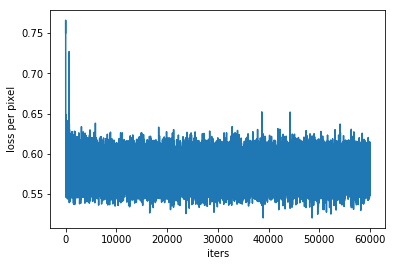

In [247]:
fig = plt.figure()
ax = plt.gca()
ax.plot(total_loss_hist)
ax.set_xlabel('iters')
ax.set_ylabel('loss per pixel')

## Exploration

In [25]:
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

In [26]:
# baseline: n-fold spatio temporal NN averaging
n_iters_ma = 1
nnma_denoised_movie_txy = ws_denoising_list[i_dataset_denoising].padded_movie_1txy[
    0, i_t_begin_denoising:i_t_end_denoising, ...].copy()
for i_iter in range(n_iters_ma):
    prev = nnma_denoised_movie_txy.copy()
    for i_t in range(1, i_t_end_denoising - i_t_begin_denoising - 1):
        nnma_denoised_movie_txy[i_t, 1:-1, 1:-1] = get_nn_spatio_temporal_mean(prev, i_t)
nnma_denoised_movie_txy = crop_center(
    nnma_denoised_movie_txy,
    target_width=ws_base_list[0].width,
    target_height=ws_base_list[0].height)

# raw
raw_movie_txy = np.zeros(
    (i_t_end_denoising - i_t_begin_denoising, ws_base_list[0].width, ws_base_list[0].height),
    dtype=np.float32)
for i_t in range(i_t_begin_denoising, i_t_end_denoising):
    raw_movie_txy[i_t - i_t_begin_denoising, ...] = \
        crop_center(
            ws_denoising_list[i_dataset_denoising].padded_movie_1txy[:, i_t, ...],
            target_width=ws_base_list[0].width,
            target_height=ws_base_list[0].height)

In [55]:
# to evaluate models at different iterations
stride = 2
model_averaging_begin_index = 0
model_averaging_end_index = 80

eval_states = []
eval_state_labels = []
for index in range(model_averaging_begin_index, model_averaging_end_index, stride):
    try:
        eval_states.append(load_model_state(model_root, model_prefix, index))
        eval_state_labels.append(str(index))
    except:
        pass
    
eval_states.append(get_swa_state_dict(
    model_root, model_prefix, model_averaging_begin_index, model_averaging_end_index))
eval_state_labels.append('SWA')

In [56]:
init_state = end_to_end_denoiser.state_dict()
denoised_movie_txy_list = []
for state, label in zip(eval_states, eval_state_labels):
    print(f'Generating denoising movie for state {label} ...')
    end_to_end_denoiser.load_state_dict(state)
    denoised_movie_txy = generate_denoised_movie(
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        end_to_end_denoiser=end_to_end_denoiser,
        i_dataset=i_dataset_denoising,
        i_t_begin=i_t_begin_denoising,
        i_t_end=i_t_end_denoising,
        x0=x0_denoising,
        y0=y0_denoising,
        x_window=x_window_denoising,
        y_window=y_window_denoising)
    denoised_movie_txy_list.append(denoised_movie_txy)
end_to_end_denoiser.load_state_dict(init_state)

# SMA movie
denoised_movie_sma_txy = get_denoised_movie_sma_txy(denoised_movie_txy_list[:-1])

Generating denoising movie for state 0 ...
Generating denoising movie for state 2 ...
Generating denoising movie for state 4 ...
Generating denoising movie for state 6 ...
Generating denoising movie for state 8 ...
Generating denoising movie for state 10 ...
Generating denoising movie for state 12 ...
Generating denoising movie for state 14 ...
Generating denoising movie for state 16 ...
Generating denoising movie for state 18 ...
Generating denoising movie for state 20 ...
Generating denoising movie for state 22 ...
Generating denoising movie for state 24 ...
Generating denoising movie for state 26 ...
Generating denoising movie for state 28 ...
Generating denoising movie for state 30 ...
Generating denoising movie for state 32 ...
Generating denoising movie for state 34 ...
Generating denoising movie for state 36 ...
Generating denoising movie for state 38 ...
Generating denoising movie for state 42 ...
Generating denoising movie for state 44 ...
Generating denoising movie for state 

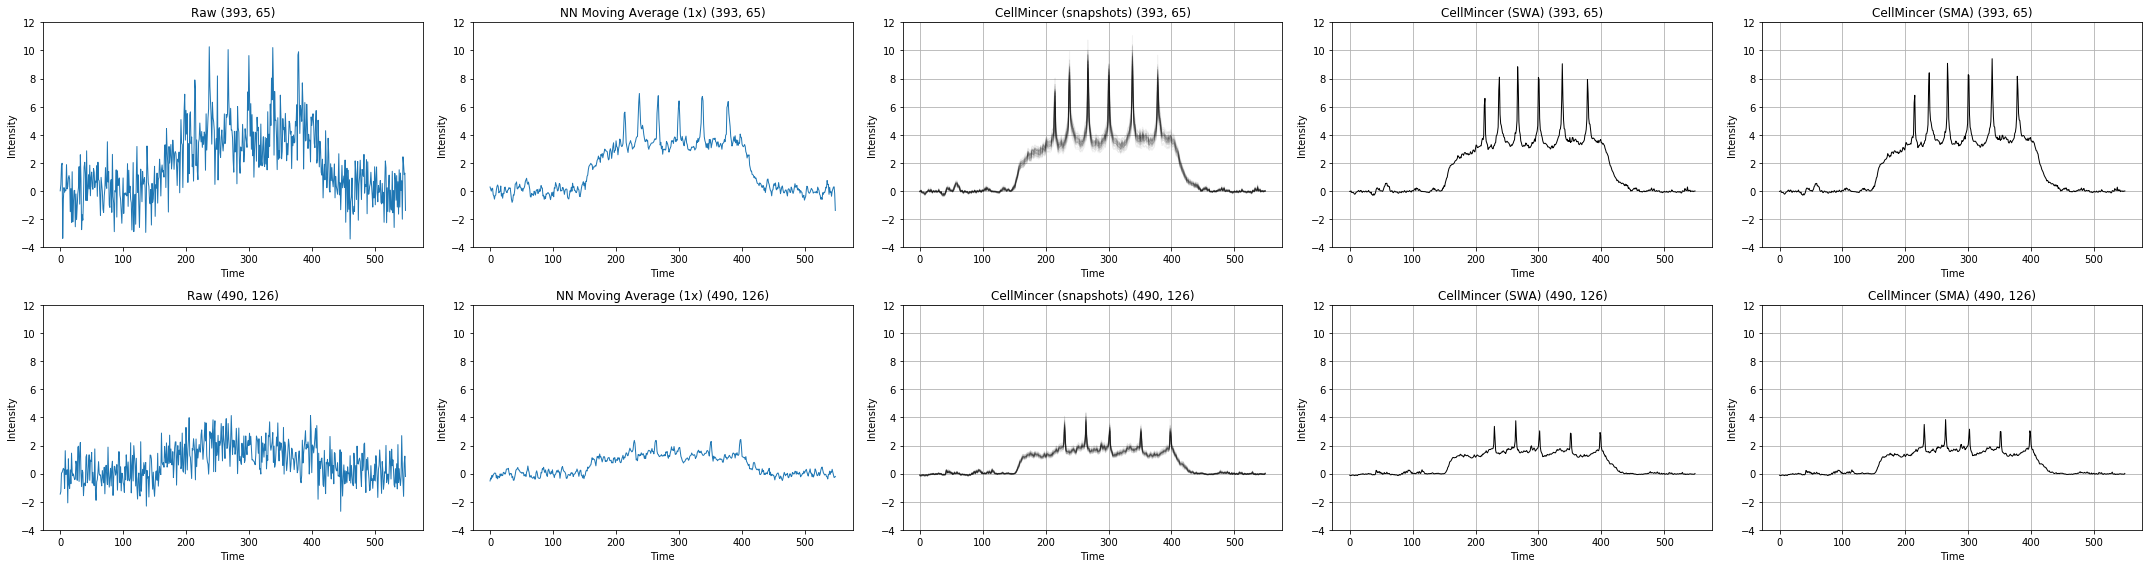

In [57]:
viz_pixels = [(393, 65), (490, 126)]
ncols = 5

fig, axs = plt.subplots(ncols=ncols, nrows=len(viz_pixels), figsize=(6 * ncols, 4 * len(viz_pixels)))

for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
    
    pixel_str = f' ({viz_x0}, {viz_y0})'
    axs[i_pixel, 0].plot(raw_movie_txy[:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 0].set_title('Raw' + pixel_str)
    axs[i_pixel, 0].set_xlabel('Time')
    axs[i_pixel, 0].set_ylabel('Intensity')

    axs[i_pixel, 1].plot(nnma_denoised_movie_txy[1:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 1].set_title(f'NN Moving Average ({n_iters_ma}x)' + pixel_str)
    axs[i_pixel, 1].set_xlabel('Time')
    axs[i_pixel, 1].set_ylabel('Intensity')

    for denoised_movie_txy, label in zip(denoised_movie_txy_list[:-1], eval_state_labels[:-1]):
        axs[i_pixel, 2].plot(denoised_movie_txy[:, viz_x0, viz_y0], label=label, lw=1, color='black', alpha=0.05)
        axs[i_pixel, 2].set_title('CellMincer (snapshots)' + pixel_str)
        axs[i_pixel, 2].set_xlabel('Time')
        axs[i_pixel, 2].set_ylabel('Intensity')
    axs[i_pixel, 2].grid()

    axs[i_pixel, 3].plot(denoised_movie_txy_list[-1][:, viz_x0, viz_y0], label=label, lw=1, color='black')
    axs[i_pixel, 3].set_title('CellMincer (SWA)' + pixel_str)
    axs[i_pixel, 3].set_xlabel('Time')
    axs[i_pixel, 3].set_ylabel('Intensity')
    axs[i_pixel, 3].grid()

    axs[i_pixel, 4].plot(denoised_movie_sma_txy[:, viz_x0, viz_y0], label=label, lw=1, color='black')
    axs[i_pixel, 4].set_title('CellMincer (SMA)' + pixel_str)
    axs[i_pixel, 4].set_xlabel('Time')
    axs[i_pixel, 4].set_ylabel('Intensity')
    axs[i_pixel, 4].grid()

ylim = (-4, 12)
for i_pixel in range(len(viz_pixels)):
    for i_col in range(ncols):
        axs[i_pixel, i_col].set_ylim(ylim)

# # lock y limits for each viz pixel
# for i_pixel in range(len(viz_pixels)):
#     min_y_lim = np.inf
#     max_y_lim = -np.inf
#     for i_col in range(ncols):
#         ylim = axs[i_pixel, i_col].get_ylim()
#         min_y_lim = min(min_y_lim, ylim[0])
#         max_y_lim = max(max_y_lim, ylim[1])
#     for i_col in range(ncols):
#         axs[i_pixel, i_col].set_ylim((min_y_lim, max_y_lim))

plt.tight_layout()
plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}.pdf')

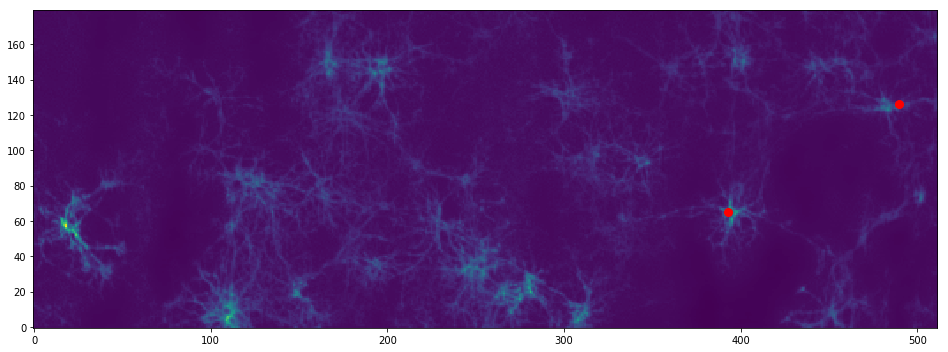

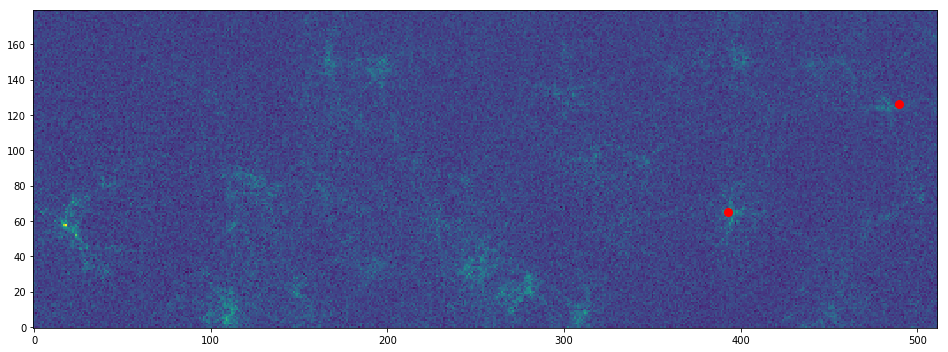

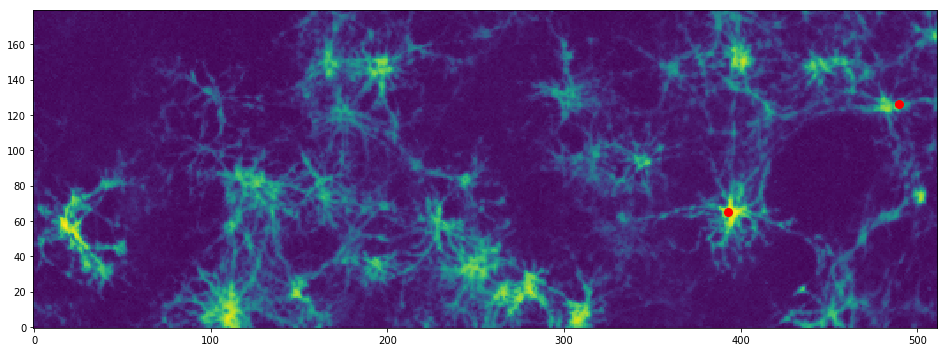

In [58]:
viz_i_t = 350

fig, ax = new_fig()
im = ax.imshow(denoised_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_denoised_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(raw_movie_txy[viz_i_t, ...].T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_raw_snapshot.pdf')

fig, ax = new_fig()
im = ax.imshow(ws_base_list[i_dataset_denoising].movie_t_corr_xy.T, origin='lower')
for (viz_x0, viz_y0) in viz_pixels:
    ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
plt.tight_layout()
plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_corr.pdf')

In [ ]:
plt.plot((denoised_movie_txy[200:500, x0, y0] - denoised_movie_txy[201:501, x0, y0]) / (
    ws_base_list[i_dataset].movie_t_std_xy[x0, y0] / ws_denoising_list[i_dataset].fg_scale))

## Generate denoised datasets

In [ ]:
for i_dataset in range(1, len(ws_base_list)):

    t_mid = (denoiser_config['t_order'] - 1) // 2
    denoised_movie_txy = np.zeros_like(ws_base_list[i_dataset].movie_txy)
    log_frequency = 500
    total_frames = ws_base_list[i_dataset].n_frames - t_mid
    t0 = time()

    for i_t in range(t_mid, total_frames):

        denoising_input_data = generate_input_for_denoising(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            i_dataset=i_dataset,
            i_t=i_t,
            t_order=denoiser_config['t_order'],
            device=device,
            dtype=dtype)

        denoised_frame_xy = denoise(
            denoising_input_data,
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            per_frame_feature_extractor=per_frame_feature_extractor,
            temporal_combiner=temporal_combiner)

        denoised_movie_txy[i_t, ...] = denoised_frame_xy.cpu().numpy()

        if (i_t - t_mid) % log_frequency == 0 and i_t > t_mid:
            fps = log_frequency / (time() - t0)
            t0 = time()
            print(f'[{opto_mov_prefixes[i_dataset]}] processed {i_t - t_mid}/{total_frames} frames ({fps:.3} fps)...')

    denoised_movie_txy[:t_mid, ...] = denoised_movie_txy[t_mid, ...]
    denoised_movie_txy[total_frames:, ...] = denoised_movie_txy[total_frames - 1, ...]

    np.save(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + '_denoised.npy'),
        denoised_movie_txy)

## Make movies

In [ ]:
import skvideo
from matplotlib.colors import Normalize

In [ ]:
# setup datasets
ws_base_list = []
for opto_mov_path in opto_mov_path_list:
    ws_base_list.append(OptopatchBaseWorkspace(opto_mov_path, logger))
n_datasets = len(ws_base_list)

In [ ]:
i_dataset = 4

In [ ]:
# write denoised movie
denoised_movie_txy = np.load(
    os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + '_denoised.npy'))

norm = Normalize(vmin=-0.5, vmax=10., clip=True)
denoised_movie_txy = (255 * norm(denoised_movie_txy)[..., None]).astype(np.uint8)

movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_denoised.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4350, 4800):
        writer.writeFrame(denoised_movie_txy[i, ...].T)
writer.close()

In [ ]:
# write raw movie
movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_raw.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4350, 4800):
        writer.writeFrame(ws_base_list[i_dataset].movie_txy[i, ...].T)
writer.close()